# Подключение библиотек и функций

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import numpy as np
from itertools import *
from ipywidgets import interactive
from IPython.display import display, clear_output
from multiprocessing import cpu_count, freeze_support
from multiprocessing.dummy import Pool
import scipy.optimize

In [3]:
def arrowplot(axes, x, y, narrs=30, dspace=0.5, direc='pos', \
                          hl=0.3, hw=6, c='black'): 
    ''' narrs  :  Number of arrows that will be drawn along the curve

        dspace :  Shift the position of the arrows along the curve.
                  Should be between 0. and 1.

        direc  :  can be 'pos' or 'neg' to select direction of the arrows

        hl     :  length of the arrow head 

        hw     :  width of the arrow head        

        c      :  color of the edge and face of the arrow head  
    '''

    # r is the distance spanned between pairs of points
    r = [0]
    for i in range(1,len(x)):
        dx = x[i]-x[i-1] 
        dy = y[i]-y[i-1] 
        r.append(np.sqrt(dx*dx+dy*dy))
    r = np.array(r)

    # rtot is a cumulative sum of r, it's used to save time
    rtot = []
    for i in range(len(r)):
        rtot.append(r[0:i].sum())
    rtot.append(r.sum())

    # based on narrs set the arrow spacing
    aspace = r.sum() / narrs

    if direc == 'neg':
        dspace = -1.*abs(dspace) 
    else:
        dspace = abs(dspace)

    arrowData = [] # will hold tuples of x,y,theta for each arrow
    arrowPos = aspace*(dspace) # current point on walk along data
                                 # could set arrowPos to 0 if you want
                                 # an arrow at the beginning of the curve

    ndrawn = 0
    rcount = 1 
    while arrowPos < r.sum() and ndrawn < narrs:
        x1,x2 = x[rcount-1],x[rcount]
        y1,y2 = y[rcount-1],y[rcount]
        da = arrowPos-rtot[rcount]
        theta = np.arctan2((x2-x1),(y2-y1))
        ax = np.sin(theta)*da+x1
        ay = np.cos(theta)*da+y1
        arrowData.append((ax,ay,theta))
        ndrawn += 1
        arrowPos+=aspace
        while arrowPos > rtot[rcount+1]: 
            rcount+=1
            if arrowPos > rtot[-1]:
                break

    # could be done in above block if you want
    for ax,ay,theta in arrowData:
        # use aspace as a guide for size and length of things
        # scaling factors were chosen by experimenting a bit

        dx0 = np.sin(theta)*hl/2. + ax
        dy0 = np.cos(theta)*hl/2. + ay
        dx1 = -1.*np.sin(theta)*hl/2. + ax
        dy1 = -1.*np.cos(theta)*hl/2. + ay

        if direc == 'neg' :
            ax0 = dx0 
            ay0 = dy0
            ax1 = dx1
            ay1 = dy1 
        else:
            ax0 = dx1 
            ay0 = dy1
            ax1 = dx0
            ay1 = dy0 

        axes.annotate('', xy=(ax0, ay0), xycoords='data',
                xytext=(ax1, ay1), textcoords='data',
                arrowprops=dict( headwidth=hw, shrink =1., ec=c, fc='white'))

#     cm = plt.get_cmap('winter')
    lc = colorline(x, y, cmap='winter')
#     plt.colorbar(lc)
#     axes.set_prop_cycle('color',plt.cm.autumn(np.linspace(0,1,100)))
    axes.plot(x,y)
#     axes.set_xlim(x.min()*.9,x.max()*1.1)
#     axes.set_ylim(y.min()*.9,y.max()*1.1)
    
def colorline(
        x, y, z=None, cmap='copper', norm=plt.Normalize(0.0, 1.0),
        linewidth=3, alpha=1.0):
    """
    http://nbviewer.ipython.org/github/dpsanders/matplotlib-examples/blob/master/colorline.ipynb
    http://matplotlib.org/examples/pylab_examples/multicolored_line.html
    Plot a colored line with coordinates x and y
    Optionally specify colors in the array z
    Optionally specify a colormap, a norm function and a line width
    """

    # Default colors equally spaced on [0,1]:
    if z is None:
        z = np.linspace(0.0, 1.0, len(x))

    # Special case if a single number:
    # to check for numerical input -- this is a hack
    if not hasattr(z, "__iter__"):
        z = np.array([z])

    z = np.asarray(z)

    segments = make_segments(x, y)
    lc = mcoll.LineCollection(segments, array=z, cmap=cmap, norm=norm,
                              linewidth=linewidth, alpha=alpha)

    ax = plt.gca()
    ax.add_collection(lc)

    return lc
def make_segments(x, y):
    """
    Create list of line segments from x and y coordinates, in the correct format
    for LineCollection: an array of the form numlines x (points per line) x 2 (x
    and y) array
    """

    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    return segments

In [23]:
def hl_plot(tpoints, xpoints, ypoints, flag = True):
    fig = plt.figure(figsize=(16,6))
    fig.add_subplot(1,2,1)
    plt.plot(tpoints,ypoints,tpoints,xpoints)
    plt.title('Hare/Lynx Population Dynamics')
    plt.xlabel('Year')
    plt.legend(['Lynx','Hare'])
    plt.grid(True)

    # plt.subplot(1,2,2)

    axes = fig.add_subplot(1,2,2)
    arrowplot(axes,xpoints,ypoints)
    plt.title('Hare/Lynx Phase Plot')
    plt.ylabel('Lynx')
    plt.xlabel('Hare')
    plt.grid(True)
    if flag:
        plotNullclines()

# Данные

In [4]:
df = pd.read_excel('data.xlsx')

In [5]:
df

,Year,Lynx,Hare
0,1900,4.0,30.0
1,1901,6.1,47.2
2,1902,9.8,70.2
3,1903,35.2,77.4
4,1904,59.4,36.3
5,1905,41.7,20.6
6,1906,19.0,18.1
7,1907,13.0,21.4
8,1908,8.3,22.0
9,1909,9.1,25.4


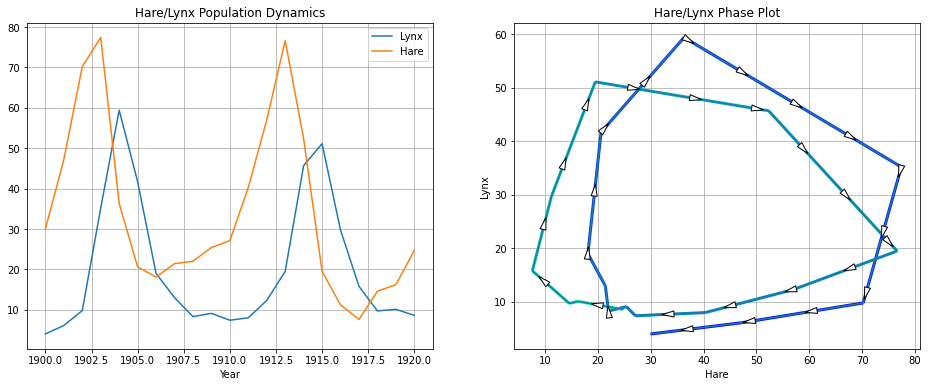

In [24]:
hl_plot(df['Year'], df['Hare'], df['Lynx'], flag = False)

# Определение параметров модели

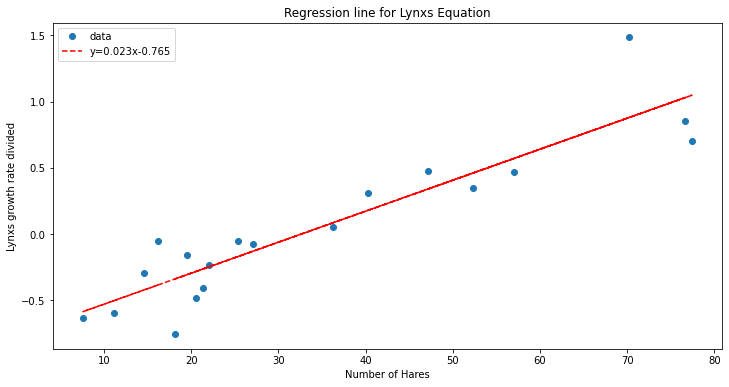

array([ 0.0234188 , -0.76455433])

In [79]:
y =[]
x = []
for k in range(19):
    y.append((1/df['Lynx'][k+1])*((df['Lynx'][k+2])-df['Lynx'][k])/2)
    x.append(df['Hare'][k+1])
    
plt.figure(figsize=(12, 6))
plt.plot(x,y,'o',)

z = np.polyfit(x, y, 1, rcond=None, full=False)
p = np.poly1d(z)

plt.plot(x,p(x),"r--")
plt.legend(['data', 'y='+str(round(z[0], 3))+'x'+str(round(z[1], 3))])
plt.xlabel("Number of Hares")
plt.ylabel("Lynxs growth rate divided")
plt.title('Regression line for Lynxs Equation')
plt.show()
z

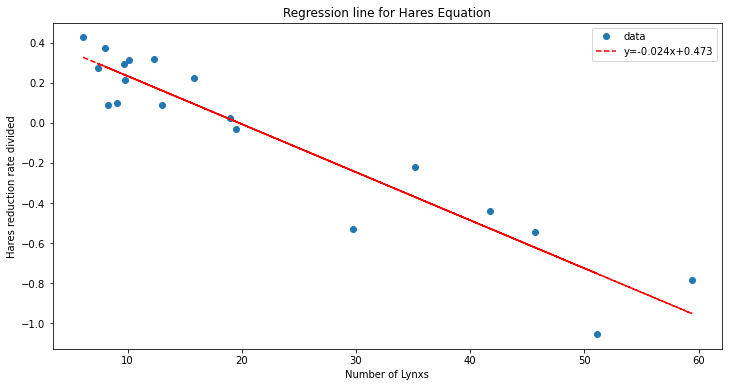

array([-0.0239853 ,  0.47318348])

In [80]:
y =[]
x = []
for k in range(19):
    y.append((1/df['Hare'][k+1])*((df['Hare'][k+2])-df['Hare'][k])/2)
    x.append(df['Lynx'][k+1])
    
plt.figure(figsize=(12, 6))
plt.plot(x,y,'o',)

z = np.polyfit(x, y, 1, rcond=None, full=False)
p = np.poly1d(z)

plt.plot(x,p(x),"r--")
plt.legend(['data', 'y='+str(round(z[0], 3))+'x+'+str(round(z[1], 3))])
plt.xlabel("Number of Lynxs")
plt.ylabel("Hares reduction rate divided")
plt.title('Regression line for Hares Equation')
plt.show()
z

In [9]:
def rk4(r, t, h, p):                   
    k1 = h*f(r, t, p)
    k2 = h*f(r+0.5*k1, t+0.5*h, p)
    k3 = h*f(r+0.5*k2, t+0.5*h, p)
    k4 = h*f(r+k3, t+h, p)
    return (k1 + 2*k2 + 2*k3 + k4)/6

def f(r, t, p):
    x, y = r[0], r[1]
    fxd = x*(p[0] - p[1]*y)
    fyd = -y*(p[3] - p[2]*x)
    return np.array([fxd, fyd], float)

def magic(r, tpoints, p):
    xpoints, ypoints  = [], []
    for t in tpoints:
        xpoints.append(r[0])          #edited
        ypoints.append(r[1])          #edited
        r += rk4(r, t, h, p)             #edited; no need for input f
    return xpoints, ypoints

def draw_plots():
    plt.figure(figsize=(12, 6))
    plt.plot(tpoints, xpoints)
    plt.plot(tpoints, df['Hare'])
    plt.xlabel("Time")
    plt.ylabel("Hare population")
    plt.title("Lotka-Volterra Model")
    plt.legend(['model', 'data'])
    plt.show()
    
    plt.figure(figsize=(12, 6))
    plt.plot(tpoints, ypoints)
    plt.plot(tpoints, df['Lynx'])
    plt.xlabel("Time")
    plt.ylabel("Lynx population")
    plt.title("Lotka-Volterra Model")
    plt.legend(['model', 'data'])
    plt.show()

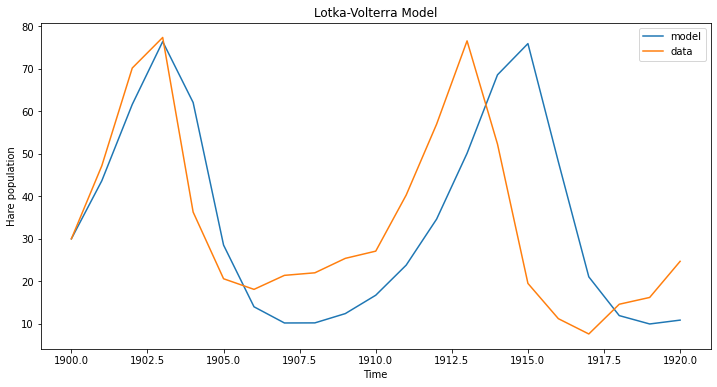

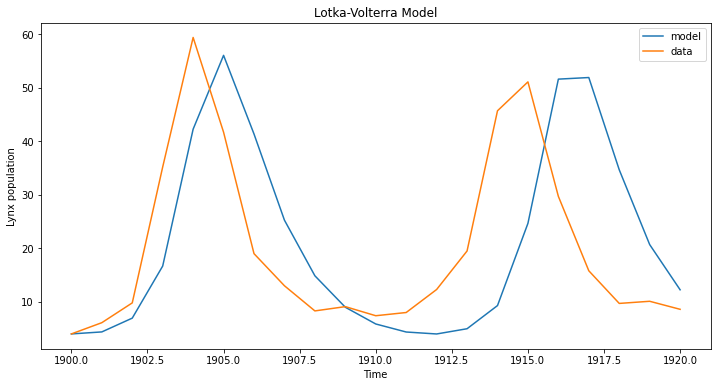

In [10]:
h=1                             
tpoints = np.arange(1900, 1921, h)         
r = np.array([30, 4], float)
p = [0.47318348 ,0.0239853, 0.0234188 , 0.76455433]
xpoints, ypoints = magic(r, tpoints, p)
draw_plots()

In [13]:
def get_error(p):
    h=1                               #edited
    tpoints = np.arange(1900, 1921, h)         #edited
    r = np.array([30, 4], float)
    xpoints, ypoints = magic(r, tpoints, p)
    return sum((np.array(xpoints)-df['Hare'])**2+(np.array(ypoints)-df['Lynx'])**2)

res = scipy.optimize.fmin(func=get_error, x0=p)

Optimization terminated successfully.
         Current function value: 731.035219
         Iterations: 77
         Function evaluations: 122


In [15]:
res

array([0.55239548, 0.0281896 , 0.02638952, 0.83704836])

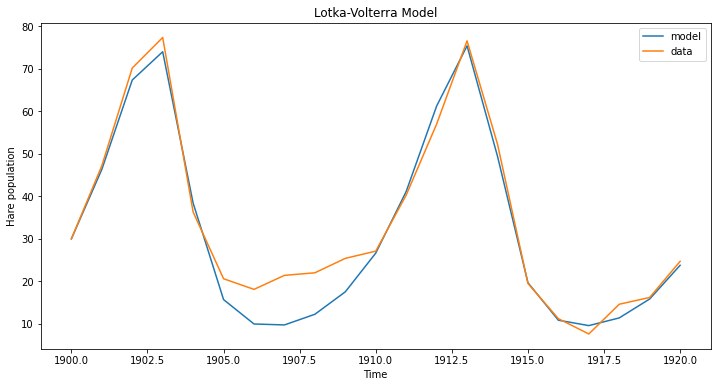

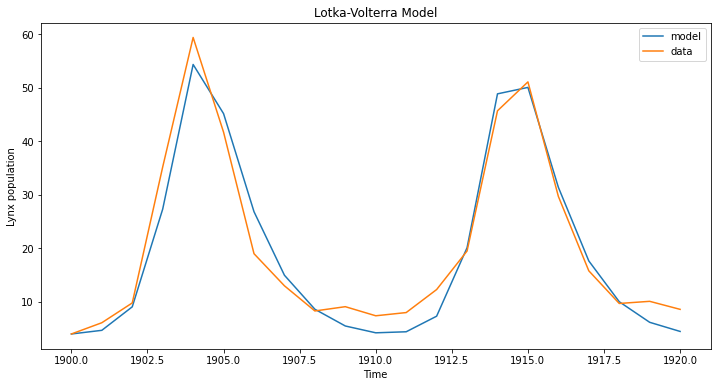

In [16]:
h=1                             
tpoints = np.arange(1900, 1921, h)         
r = np.array([30, 4], float)
p = res
xpoints, ypoints = magic(r, tpoints, p)
draw_plots()

In [18]:
def plotNullclines():
    # nullcline dH/dt = 0
    maxi = 100
    Lp = p[0]/p[1]
    plt.plot([0, plt.xlim()[1]],[Lp, Lp],'-')
    
#     plt.ylim(0,maxi)
#     plt.xlim(0,maxi)
    
    # nullcline dL/dt = 0
    Hd = p[3]/p[2]
    plt.plot([Hd,Hd],[0, plt.ylim()[1]],0,'-')

    # additional nullclines
    plt.plot([0,0],plt.ylim(),'b')
    plt.plot(plt.xlim(),[0,0],'r')

    # steady states
#     Hss = c*d/(a*b-d)
#     Lss = r*(1-Hss/k)*(c+Hss)/a
    plt.plot(Hd,Lp,'o',ms=15)

    plt.xlabel('Hare')
    plt.ylabel('Lynx')
    plt.legend(['dH/dt = 0','dL/dt = 0'])  

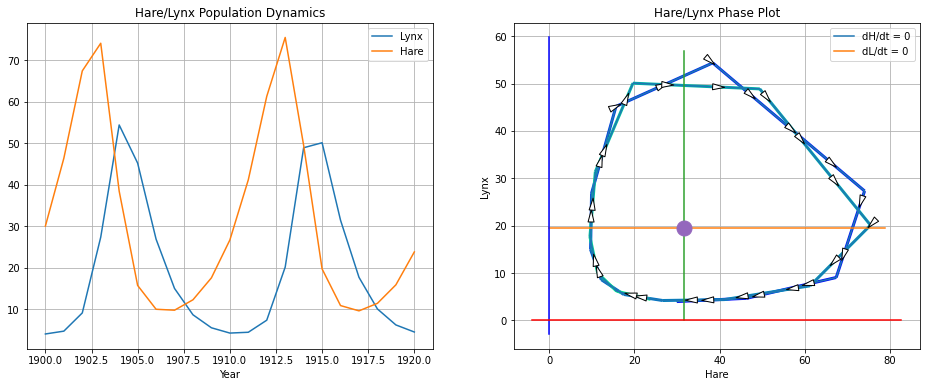

In [20]:
hl_plot(tpoints, xpoints, ypoints)

In [21]:
# from scipy.integrate import odeint

# perform simulation
t = np.arange(1900,1970,1)

def LynxHare(H=30,L=4,alpha=p[0]):
    IC = [H,L]
#     global a
#     a = aslider
#     sol = odeint(f,IC,t)
    pnew = p.copy()
    pnew[0] = alpha
    xpoints, ypoints = magic(IC, t, pnew)
#     sol = odeint(f, IC, t)
#     hl_plot(t,sol[:,0],sol[:,1])
    hl_plot(t, xpoints, ypoints)

In [26]:
from ipywidgets import interact
interact(LynxHare, H = (0,80,1), L =(0,80,1), alpha=(0,1,0.01))

interactive(children=(IntSlider(value=30, description='H', max=80), IntSlider(value=4, description='L', max=80…

<function __main__.LynxHare(H=30, L=4, alpha=0.55239548)>

No handles with labels found to put in legend.


(0.0, 80.85829726587995)

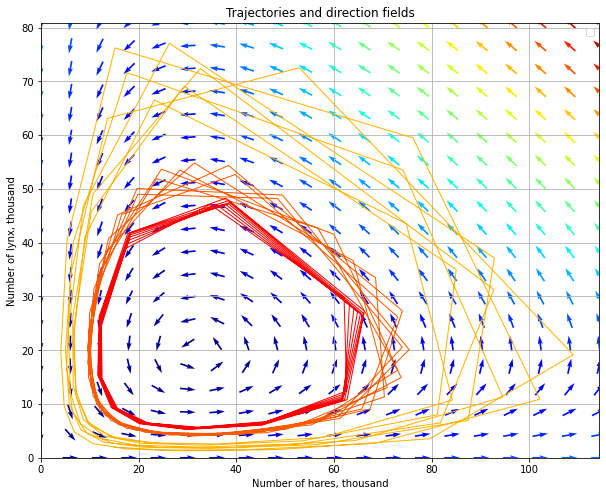

In [33]:
# values  = np.linspace(0.025, 2, 5)   
values = [0.5, 1, 1.5]
vcolors = plt.cm.autumn_r(np.linspace(0.3, 1., len(values)))  # colors for each trajectory
r = np.array([30,4], float)

#!python

f2 = plt.figure(figsize = (10, 8))
tpoints = np.arange(1900, 1940, 0.5)
#-------------------------------------------------------
# plot trajectories
for v, col in zip(values, vcolors):
    X0 = v * r 
    X = magic(X0, tpoints, p)      # we don't need infodict here
    plt.plot( X[0], X[1], color=col,  linewidth=1)

# -------------------------------------------------------
# define a grid and compute direction at each point
ymax = plt.ylim(ymin=0)[1]                        # get axis limits
xmax = plt.xlim(xmin=0)[1]
nb_points = 20

x = np.linspace(0, xmax, nb_points)
y = np.linspace(0, ymax, nb_points)

X1 , Y1  = np.meshgrid(x, y)  
DX1, DY1 = f([X1, Y1], 0, p)
# compute growth rate on the gridt
M = (np.hypot(DX1, DY1))                        # Norm of the growth rate 
M[M == 0] = 1.                                 # Avoid zero division errors 
DX1 /=M                               # Normalize each arrows
DY1 /=M

#-------------------------------------------------------
# Drow direction fields, using matplotlib 's quiver function
# I choose to plot normalized arrows and to use colors to give information on
# the growth speed
plt.title('Trajectories and direction fields')
Q = plt.quiver(X1, Y1, DX1, DY1, M, pivot='mid', cmap=plt.cm.jet)
plt.xlabel('Number of hares, thousand')
plt.ylabel('Number of lynx, thousand')
plt.legend()
plt.grid()
plt.xlim(0, xmax)
plt.ylim(0, ymax)

# Литература
1. https://jmahaffy.sdsu.edu/courses/f09/math636/lectures/lotka/qualde2.html
2. https://www.math.tamu.edu/~phoward/m442/modbasics.pdf
3. https://math-it.petrsu.ru/users/semenova/MathECO/Lections/Lotka_Volterra.pdf
4. https://jckantor.github.io/CBE30338/02.05-Hare-and-Lynx-Population-Dynamics.html
5. https://scipy-cookbook.readthedocs.io/items/LoktaVolterraTutorial.html
6. https://mc-stan.org/users/documentation/case-studies/lotka-volterra-predator-prey.html#solving-the-inverse-problem-bayesian-inference-in-stan
7. https://nplus1.ru/material/2019/12/04/lotka-volterra-model
8. https://en.wikipedia.org/wiki/Canada_lynx